In [2]:
from IPython.display import Image, display

from openai import OpenAI
from dotenv import load_dotenv
import graphviz
load_dotenv()

True

In [77]:
class iAgent:
    """
    simple demo
    """
    def __init__(self,name: str,description: str):
        self.name = name
        self.description = description
        self.client = OpenAI()

    def chat(self, messages: list|str):
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "system", "content": self.description}] + messages,
            )
        return [{"role": "assistant", "content": response.choices[0].message.content,"sender": self.name}]

In [78]:
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class AgentSchema:
    """
    This class defines the schema of the agent used for the handoff process.
    """
    name: str
    transfer_to_me_description: str
    agent: iAgent
    relations: Optional[List[str]] = None # agent names that this agent can transfer to
    as_entry: Optional[bool] = False
    as_exit: Optional[bool] = False


In [178]:
from typing import Literal
import random
from collections import defaultdict, deque

class Group:
    def __init__(self, 
                 participants: list[AgentSchema], 
                 model_client: OpenAI = OpenAI()
                 ):
        
        self.participants = participants
        self.model_client = model_client
        self.entry_agent = next((p for p in participants if p.as_entry), random.choice(participants))
        self.current_agent = self.entry_agent
        self.exit_agent = next((p for p in participants if p.as_exit), None)
        self.agent_map = {p.name: p for p in participants}
        self.handoff_tools = []
        self.participants_order_map = self._build_participant_order_map()
        self.group_structure = self._decide_group_structure()

    def reset(self):
        """
        Resets the state of the framework by setting the current agent to the first participant
        that has the 'as_entry' attribute set to True.
        """
        self.entry_agent = next((p for p in self.participants if p.as_entry), random.choice(self.participants))
        self.current_agent = self.entry_agent


    def handoff_one_turn(self, 
                         messages: list|str,
                         model:str="gpt-4o-mini",
                         next_speaker_select_mode:Literal["order","auto","random"]="auto",
                         include_current:bool = True,
                         verbose=False
                         ):

        if next_speaker_select_mode == "order":
            if self.group_structure != "CONNECTED":
                raise ValueError("next_speaker_select_mode 'order' is only supported when group_structure is 'CONNECTED'")
            next_agent = self.participants_order_map[self.current_agent.name]
            if verbose:
                print(f"[order] handoff from {self.current_agent.name} to {next_agent}")
            self.current_agent = self.agent_map[next_agent]
            return next_agent
        
        elif next_speaker_select_mode == "random":
            next_agent = random.choice(self.agent_names)
            if verbose:
                print(f"[random] handoff from {self.current_agent.name} to {next_agent}")
            self.current_agent = self.agent_map[next_agent]
            return next_agent
 
        elif next_speaker_select_mode == "auto":
            
            self._build_current_handoff_tools(include_current=include_current)
    
            if isinstance(messages, str):
                messages = [{"role": "user", "content": messages}]
            messages = [{"role": "system", "content":"deciding which agent to transfer to"}] + messages

            response = self.model_client.chat.completions.create(
                        model=model,
                        messages=messages,
                        tools=self.handoff_tools,
                        tool_choice="required"
                    )
            next_agent = response.choices[0].message.tool_calls[0].function.name

            if next_agent in self.agent_names:
                if self.current_agent.name != next_agent and verbose:
                    print("[auto] handoff from {} to {}".format(self.current_agent.name, next_agent))
                self.current_agent = self.agent_map[next_agent]
            else:
                raise ValueError(f"Handoff to unknown agent: {next_agent}")

            return next_agent
    
        else:
            raise ValueError(f"Unknown next_speaker_select_mode: {next_speaker_select_mode} , Currently only 'order', 'random' and 'auto' are supported")

    def handoff(self, 
                messages: list|str,
                model:str="gpt-4o-mini",
                handoff_max_turns:int=10,
                next_speaker_select_mode:Literal["order","auto","random"]="auto",
                include_current = True,
                verbose=False
                ):

        next_agent = self.handoff_one_turn(messages,model,next_speaker_select_mode,include_current,verbose)
        if next_speaker_select_mode != "auto" or handoff_max_turns == 1:
            return next_agent
        next_next_agent =  self.handoff_one_turn(messages,model,"auto",include_current,verbose)
        while next_next_agent != next_agent and handoff_max_turns > 1:
            next_agent = next_next_agent
            next_next_agent = self.handoff_one_turn(messages,model,"auto",include_current,verbose)
            handoff_max_turns -= 1
        return next_agent


    def chat(self, 
             messages: list|str,
             model:str="gpt-4o-mini",
             next_speaker_select_mode:Literal["auto","random"]="auto",
             entry_agent:str=None,
             verbose=False
             ):
        if entry_agent and entry_agent in self.agent_names:
            self.current_agent = self.agent_map[entry_agent]
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        next_agent = self.handoff(messages,model,10,next_speaker_select_mode,True,verbose)
        return self.agent_map[next_agent].agent.chat(messages)


    def task(self,
             task:str,
             model:str="gpt-4o-mini",
             verbose=False
            ):
        if self.group_structure != "DAG":
            raise ValueError("task is only supported when group_structure is 'DAG' and DAG must have both entry and exit agents")

    def discussion(self,
                   topic:str,
                   model:str="gpt-4o-mini",
                   max_turns:int=5,
                   next_speaker_select_mode:Literal["order","auto","random"]="order",
                   verbose=False
                   ):
        if self.group_structure != "CONNECTED":
            raise ValueError("discussion is only supported when group_structure is 'CONNECTED'")
        self.reset()
        content = topic
        messages = [{"role": "user", "content": content}]
        next_agent = self.current_agent.name
        while max_turns > 0:
            response = self.agent_map[next_agent].agent.chat(messages)
            print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")
            content += """
            \n\n```{} say: {}\n\n```""".format(next_agent,response[0]["content"])
            messages = [{"role": "user", "content": content + "\n\n### Topic {} \n\n### Task\n\n consider your own previous opinion and the previous speaker's opinion, and then give your own opinion".format(topic)}]
            max_turns -= 1
            next_agent = self.handoff(messages,model,1,next_speaker_select_mode,False,verbose)
            
    @property
    def agent_names(self):
        """
        Returns:
            list: A list of names of all participants.
        """
        return [p.name for p in self.participants]
    
    @property
    def relations(self):
        """
        Returns:
            list: A list of tuples representing the relations between participants.
                Each tuple contains the name of a participant and the name of a related participant.
        """
        relations = [("START", self.entry_agent.name)]
        if self.exit_agent:
            relations.append((self.exit_agent.name, "END"))
        if all(not hasattr(p, 'relations') or p.relations is None for p in self.participants):
            for i in range(len(self.participants)):
                for j in range(len(self.participants)):
                    if i != j:
                        relations.append((self.participants[i].name, self.participants[j].name))
        else:
            for p in self.participants:
                if hasattr(p, 'relations') and isinstance(p.relations, list):
                    relations.extend((p.name, r) for r in p.relations)
        return relations
    
    @property
    def relation_agents(self):
        """
        Returns:
            dict: A dictionary where the keys are participant names and the values are lists of AgentSchema objects
                representing the related agents.
        """
        if self.group_structure == "CUSTOM" or self.group_structure == "DAG":
            return {p.name: [self.agent_map[r] for r in p.relations] if p.relations else [] for p in self.participants}
        elif self.group_structure == "CONNECTED":
            return {p.name: [a for a in self.participants if a.name != p.name] for p in self.participants}
    

    def draw_relations(self):
        """ 
        Returns:
            bytes: A PNG image of the graph representing the relations between participants.
        """
        dot = graphviz.Digraph(format='png')
        dot.node("START", "START", shape='rect', color='gray', fontcolor='gray')
        for p in self.participants:
            dot.node(p.name, p.name, color='orange' if p.name == self.current_agent.name else 'black')
        for r in self.relations:
            dot.edge(r[0], r[1])
        return dot.pipe()

    def _build_current_handoff_tools(self, include_current=True):
        """ 
        Builds the handoff tools based on the current agent and its related agents.

        Args:
            include_current (bool, optional): Whether to include the current agent in the handoff tools. Defaults to True.

        Returns:
            list: A list of handoff tools.
        """
        self.handoff_tools = [self._build_agent_schema(self.current_agent)] if include_current else []
        self.handoff_tools.extend(self._build_agent_schema(r) for r in self.relation_agents[self.current_agent.name])

    @staticmethod
    def _build_agent_schema(agent: AgentSchema):
        """
        Builds the schema for the given agent. 
        """
        return {
            "type": "function",
            "function": {
                "name": agent.name,
                "description": agent.transfer_to_me_description,
                "parameters": {"type": "object", "properties": {}, "required": []}
            }
        }
    
    def _build_participant_order_map(self):
        """
        Builds a map of participants in order.

        Returns:
            dict: A dictionary mapping participant names to the next participant in order.
        """
        return {p.name: self.participants[(i+1) % len(self.participants)].name for i, p in enumerate(self.participants)}
    

    def _decide_group_structure(self):
        # if all participants do not have relations, then group_structure is CONNECTED
        if all(not hasattr(p, 'relations') or p.relations is None for p in self.participants):
            return "CONNECTED"
        # if any participant has relations, and entry and exit agents are defined, and no circular relations, then group_structure is DAG
        if any(hasattr(p, 'relations') and p.relations for p in self.participants) and self.entry_agent and self.exit_agent:
            if self._is_valid_dag(self.relations):
                return "DAG"
            else:
                print("[Warning] You may want to construct a DAG but now this is an invalid DAG , Setting group_structure to CUSTOM temporarily")
        return "CUSTOM"
    
 
    @staticmethod
    def _is_valid_dag(relations):
        # Build the graph
        graph = defaultdict(list)
        reverse_graph = defaultdict(list)
        nodes = set()
        for u, v in relations:
            graph[u].append(v)
            reverse_graph[v].append(u)
            nodes.update([u, v])

        # Check for cycles using DFS
        def has_cycle(v, visited, rec_stack):
            visited.add(v)
            rec_stack.add(v)
            for neighbor in graph[v]:
                if neighbor not in visited:
                    if has_cycle(neighbor, visited, rec_stack):
                        return True
                elif neighbor in rec_stack:
                    return True
            rec_stack.remove(v)
            return False

        visited = set()
        rec_stack = set()
        for node in list(graph.keys()):  # Iterate over a list of the dictionary keys
            if node not in visited:
                if has_cycle(node, visited, rec_stack):
                    print("[DAG INVALID] Cycle detected")
                    return False

        # Check if all nodes are reachable from 'START'
        def bfs_reachable_from_start(start):
            queue = deque([start])
            visited = set()
            while queue:
                node = queue.popleft()
                if node not in visited:
                    visited.add(node)
                    queue.extend(graph[node])
            return visited

        # Check if all nodes can reach 'END'
        def bfs_reachable_to_end(end):
            queue = deque([end])
            visited = set()
            while queue:
                node = queue.popleft()
                if node not in visited:
                    visited.add(node)
                    queue.extend(reverse_graph[node])
            return visited

        reachable_from_start = bfs_reachable_from_start('START')
        reachable_to_end = bfs_reachable_to_end('END')

        if nodes != reachable_from_start:
            missing_nodes = nodes - reachable_from_start
            print(f"[DAG INVALID] Nodes not reachable from START: {missing_nodes}")
            return False

        if nodes != reachable_to_end:
            missing_nodes = nodes - reachable_to_end
            print(f"[DAG INVALID] Nodes not reachable to END: {missing_nodes}")
            return False

        return True

In [194]:
mathematician = iAgent(name="mathematician", description="You are a mathmatician,reply use daily language")
artist = iAgent(name="artist", description="You are an artist,reply use daily language")
architect = iAgent(name="architect", description="You are an architect,reply use daily language")

physicist = iAgent(name="physicist", description="You are a physicist,reply use daily language")

mathematician_schema = AgentSchema(name="mathematician",
                            transfer_to_me_description="Call me if you have any questions about math.",
                            agent=mathematician,
                            as_entry=True,
                            relations=["artist","physicist"])

artist_schema = AgentSchema(name="artist",
                            transfer_to_me_description="Call me if you have any questions about art.",
                            agent=artist,
                            relations=["architect"])

physicist_schema = AgentSchema(name="physicist",
                            transfer_to_me_description="Call me if you have any questions about physics.",
                            agent=physicist,
                            relations=["architect"])

architect_schema = AgentSchema(name="architect",
                            transfer_to_me_description="Call me if you have any questions about architecture.",
                            agent=architect,
                            as_exit=True)


In [195]:
g = Group(participants=[mathematician_schema, artist_schema, architect_schema,physicist_schema])

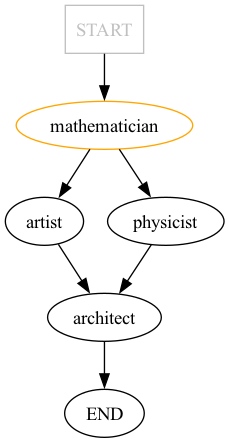

In [196]:
display(Image(g.draw_relations()))

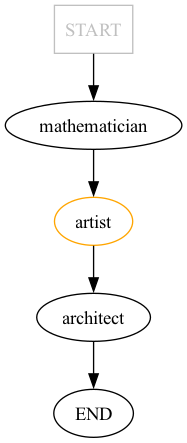

[{'role': 'assistant', 'content': 'Art is pretty much anything created to express ideas, emotions, or a view of the world. It can be painting, music, dance, sculpture, writing—pretty much any form of creativity. It’s a way for people to connect, share their thoughts, and tell stories. What’s cool about art is that it means different things to different people, and it can stir up all kinds of feelings. So, whether you’re looking at a painting, listening to a song, or watching a play, it’s all about exploring and experiencing those unique moments!', 'sender': 'artist'}]


In [85]:
response = g.chat("what is art",verbose=True)
display(Image(g.draw_relations()))
print(response)

[random] handoff from architect to artist


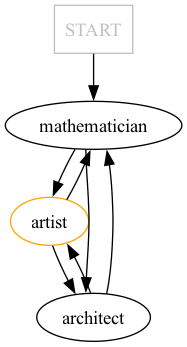

In [16]:
g.chat("how to build a house",next_speaker_select_mode="random",verbose=True)
display(Image(g.draw_relations()))

In [422]:
g.discussion("what is beauty'",max_turns=5,next_speaker_select_mode="order",verbose=True)



[mathematician] 

 Beauty can be a bit tricky to define because it often depends on personal feelings and cultural influences. Generally, beauty is about qualities that give pleasure to the senses or the mind. It can be found in nature, art, music, and even in people. Some might say it's about balance, color, symmetry, or even emotional connections. 

Ultimately, what one person finds beautiful, another might not, and that's part of what makes beauty so interesting! It's really about how things make us feel.
overriding default next_speaker_select_mode with order
[order] handoff from mathematician to artist


[artist] 

 I totally agree with the idea that beauty is super subjective. What makes something beautiful can vary so much from person to person and culture to culture. For me, beauty is often found in the little details—the way light plays on leaves, the texture of a canvas, or the emotion in a song. It's about the feelings those things evoke in us.

I think beauty also has a lo

In [ ]:
from collections import defaultdict, deque



# Example usage
relations = [
    ('START', 'mathematician'),
    ('architect', 'END'),
    ('mathematician', 'artist'),
    ('artist', 'architect')
]

print(_is_valid_dag(relations))  # Output: True or False

True
